In [65]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import torch
from torchvision import datasets, transforms

from torch import nn, optim
import torch.nn.functional as F

from sklearn.manifold import TSNE

In [49]:
# seed 
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [50]:
# set device
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [51]:
# load MINST dataset, train + test as dataset


# define a transform to normalize the data
transform_ = transforms.Compose([transforms.ToTensor()])

# download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform_)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform_)

data = torch.utils.data.ConcatDataset([trainset, testset])

# make custum train, val and test sets from data in ratio 0.7, 0.1 and 0.2
train_size = int(0.7 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size

train_data, val_data, test_data = torch.utils.data.random_split(data, [train_size, val_size, test_size])

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [52]:
# make a noisy dataset by adding gaussian noise to the images
def add_noise(data, noise_factor=0.1):
    noisy_data = data + noise_factor * torch.randn(data.size())
    return torch.clamp(noisy_data, 0., 1.)

## CAE

In [53]:
class CAE(nn.Module):
    def __init__(self, encode_layers, encode_kernels, decode_layers, decode_kernels, latent_size=None):
        super(CAE, self).__init__()

        self.encode_layers = encode_layers
        self.encode_kernels = encode_kernels
        self.decode_layers = decode_layers
        self.decode_kernels = decode_kernels
        
        # define encoder as module list
        self.encoder = nn.ModuleList()

        # define encoder layers
        for i in range(len(encode_layers)):
            if i == 0:
                self.encoder.append(nn.Conv2d(1, encode_layers[i], encode_kernels[i], padding=1, stride=2))
            else:
                self.encoder.append(nn.Conv2d(encode_layers[i-1], encode_layers[i], encode_kernels[i], padding=1, stride=2))

        flat_size = 28
        for i in range(len(encode_layers)):
            flat_size = (flat_size - encode_kernels[i] + 2) // 2 + 1
        self.flat_size = flat_size

        # define decoder as module list
        self.decoder = nn.ModuleList()

        # define decoder layers
        for i in range(len(decode_layers)):
            if i == 0:
                self.decoder.append(nn.ConvTranspose2d(encode_layers[-1], decode_layers[i], decode_kernels[i], stride=2, padding=1, output_padding=1))
            else:
                self.decoder.append(nn.ConvTranspose2d(decode_layers[i-1], decode_layers[i], decode_kernels[i], stride=2, padding=1, output_padding=1))

        self.fc1 = nn.Linear(flat_size*flat_size*encode_layers[-1], latent_size)
        self.fc2 = nn.Linear(latent_size, flat_size*flat_size*encode_layers[-1])

    def forward(self, x):
        print_flag = False
        for layer in self.encoder:
            x = layer(x)
            x = F.relu(x)
            if (print_flag): print(f'encoder: { x.shape }')

        x = x.view(-1, self.flat_size*self.flat_size*self.encode_layers[-1])
        if (print_flag): print(f'flatten: { x.shape }')
        x = F.relu(self.fc1(x))
        if (print_flag): print(f'fc1: { x.shape }')
        x = F.relu(self.fc2(x))
        if (print_flag): print(f'fc2: { x.shape }')
        x = x.view(-1, self.encode_layers[-1], self.flat_size, self.flat_size)
        if (print_flag): print(f'unflatten: { x.shape }')

        for layer in self.decoder:
            x = layer(x)
            x = F.relu(x)
            if (print_flag): print(f'decoder: { x.shape }')

        return x
    
    def encode(self, x):
        for layer in self.encoder:
            x = layer(x)
            x = F.relu(x)
        x = x.view(-1, self.flat_size*self.flat_size*self.encode_layers[-1])
        x = F.relu(self.fc1(x))
        return x
    
    def decode(self, x):
        x = F.relu(self.fc2(x))
        x = x.view(-1, self.encode_layers[-1], self.flat_size, self.flat_size)
        for layer in self.decoder:
            x = layer(x)
            x = F.relu(x)
        return x
        

In [54]:
def trainCAE(model, train_loader, val_loader, optimizer, criterion, epochs=10, lr=0.001, output_dir='output_cae'):
    train_losses = []
    val_losses = []

    best_err = 1e10

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # open log file
    log_file = open(f"{output_dir}/log.txt", "w")

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, _ in tqdm(train_loader):
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()

        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))

        print(f"Epoch {epoch+1}/{epochs} "
              f"Train loss: {running_loss/len(train_loader):.3f} "
              f"Val loss: {val_loss/len(val_loader):.3f}")
        
        log_file.write(f"Epoch {epoch+1}/{epochs} "
                f"Train loss: {running_loss/len(train_loader):.3f} "
                f"Val loss: {val_loss/len(val_loader):.3f}\n")
        
        if val_loss < best_err:
            best_err = val_loss
            torch.save(model.state_dict(), f"{output_dir}/best_model.pth")
            print(f"Best model saved with loss: {best_err}, at epoch: {epoch+1}")

    # save last model
    torch.save(model.state_dict(), f"{output_dir}/last_model.pth")
    log_file.close()
            

In [69]:
# train noisy cae, in loss compare noisy and clean images
def trainNoisyCAE(model, train_loader, val_loader, epochs=10, lr=0.001, output_dir='output_cae', noise_factor=0.5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []

    best_err = 1e10

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # open log file
    log_file = open(f"{output_dir}/log.txt", "w")

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, _ in tqdm(train_loader):
            images = images
            noisy_images = add_noise(images, noise_factor=noise_factor).to(device)
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images
                noisy_images = add_noise(images, noise_factor=noise_factor).to(device)
                images = images.to(device)
                outputs = model(noisy_images)
                loss = criterion(outputs, images)
                val_loss += loss.item()

        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))

        print(f"Epoch {epoch+1}/{epochs} "
              f"Train loss: {running_loss/len(train_loader):.3f} "
              f"Val loss: {val_loss/len(val_loader):.3f}")
        
        log_file.write(f"Epoch {epoch+1}/{epochs} "
                f"Train loss: {running_loss/len(train_loader):.3f} "
                f"Val loss: {val_loss/len(val_loader):.3f}\n")
        
        if val_loss < best_err:
            best_err = val_loss
            torch.save(model.state_dict(), f"{output_dir}/best_model.pth")
            print(f"Best model saved with loss: {best_err}, at epoch: {epoch+1}")

    # save last model
    torch.save(model.state_dict(), f"{output_dir}/last_model.pth")
    log_file.close()
    

In [56]:
def testCAE(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            test_loss += loss.item()

    print(f"Test loss: {test_loss/len(test_loader):.3f}")

    return test_loss/len(test_loader)

In [60]:
config1 = {
    'encode_layers': [16, 32],
    'encode_kernels': [3, 3],
    'decode_layers': [16, 1],
    'decode_kernels': [3, 3],
    'latent_size': 100
}
config2 = {
    'encode_layers': [16, 32],
    'encode_kernels': [7, 7],
    'decode_layers': [16, 1],
    'decode_kernels': [7, 7],
    'latent_size': 100
}
config3 = {
    'encode_layers': [16, 32],
    'encode_kernels': [3, 5],
    'decode_layers': [16, 1],
    'decode_kernels': [5, 3],
    'latent_size': 64
}
# print parameters size for each configuration
model = CAE(**config1).to(device)
print(f"Model 1: {sum(p.numel() for p in model.parameters())}")
model = CAE(**config2).to(device)
print(f"Model 2: {sum(p.numel() for p in model.parameters())}")
model = CAE(**config3).to(device)
print(f"Model 3: {sum(p.numel() for p in model.parameters())}")

Model 1: 324837
Model 2: 154821
Model 3: 174625


In [58]:
def trainCAE_config(config, config_num):
    model = CAE(**config).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    output_dir = os.getcwd()
    output_dir = f'{output_dir}/output_cae_{config_num}'

    trainCAE(model, train_loader, val_loader, optimizer, criterion, epochs=10, lr=0.001, output_dir=output_dir)

    testCAE(model, test_loader, criterion)

In [59]:
trainCAE_config(config1, 1)
trainCAE_config(config2, 2)
trainCAE_config(config3, 3)

100%|██████████| 766/766 [00:04<00:00, 155.57it/s]


Epoch 1/10 Train loss: 0.017 Val loss: 0.008
Best model saved with loss: 0.827807389665395, at epoch: 1


100%|██████████| 766/766 [00:04<00:00, 156.09it/s]


Epoch 2/10 Train loss: 0.006 Val loss: 0.006
Best model saved with loss: 0.614054711535573, at epoch: 2


100%|██████████| 766/766 [00:04<00:00, 153.95it/s]


Epoch 3/10 Train loss: 0.005 Val loss: 0.005
Best model saved with loss: 0.5482537276111543, at epoch: 3


100%|██████████| 766/766 [00:04<00:00, 157.84it/s]


Epoch 4/10 Train loss: 0.005 Val loss: 0.005
Best model saved with loss: 0.5074157351627946, at epoch: 4


100%|██████████| 766/766 [00:04<00:00, 153.46it/s]


Epoch 5/10 Train loss: 0.004 Val loss: 0.005
Best model saved with loss: 0.5032869507558644, at epoch: 5


100%|██████████| 766/766 [00:04<00:00, 156.27it/s]


Epoch 6/10 Train loss: 0.004 Val loss: 0.004
Best model saved with loss: 0.4647324939724058, at epoch: 6


100%|██████████| 766/766 [00:04<00:00, 156.26it/s]


Epoch 7/10 Train loss: 0.004 Val loss: 0.004
Best model saved with loss: 0.46379009797237813, at epoch: 7


100%|██████████| 766/766 [00:04<00:00, 156.31it/s]


Epoch 8/10 Train loss: 0.004 Val loss: 0.004
Best model saved with loss: 0.44140095287002623, at epoch: 8


100%|██████████| 766/766 [00:04<00:00, 155.95it/s]


Epoch 9/10 Train loss: 0.004 Val loss: 0.004
Best model saved with loss: 0.43869163282215595, at epoch: 9


100%|██████████| 766/766 [00:04<00:00, 157.41it/s]


Epoch 10/10 Train loss: 0.004 Val loss: 0.004
Best model saved with loss: 0.4270334818866104, at epoch: 10
Test loss: 0.004


100%|██████████| 766/766 [00:04<00:00, 154.87it/s]


Epoch 1/10 Train loss: 0.019 Val loss: 0.009
Best model saved with loss: 0.9956472092308104, at epoch: 1


100%|██████████| 766/766 [00:04<00:00, 158.21it/s]


Epoch 2/10 Train loss: 0.008 Val loss: 0.007
Best model saved with loss: 0.7255148887634277, at epoch: 2


100%|██████████| 766/766 [00:04<00:00, 157.67it/s]


Epoch 3/10 Train loss: 0.006 Val loss: 0.006
Best model saved with loss: 0.6211062981747091, at epoch: 3


100%|██████████| 766/766 [00:04<00:00, 158.86it/s]


Epoch 4/10 Train loss: 0.005 Val loss: 0.005
Best model saved with loss: 0.548297381028533, at epoch: 4


100%|██████████| 766/766 [00:04<00:00, 158.14it/s]


Epoch 5/10 Train loss: 0.005 Val loss: 0.005
Best model saved with loss: 0.5018365648575127, at epoch: 5


100%|██████████| 766/766 [00:04<00:00, 158.60it/s]


Epoch 6/10 Train loss: 0.004 Val loss: 0.004
Best model saved with loss: 0.47702241130173206, at epoch: 6


100%|██████████| 766/766 [00:04<00:00, 158.60it/s]


Epoch 7/10 Train loss: 0.004 Val loss: 0.004
Best model saved with loss: 0.4617792230565101, at epoch: 7


100%|██████████| 766/766 [00:04<00:00, 156.75it/s]


Epoch 8/10 Train loss: 0.004 Val loss: 0.004
Best model saved with loss: 0.43701893254183233, at epoch: 8


100%|██████████| 766/766 [00:04<00:00, 158.52it/s]


Epoch 9/10 Train loss: 0.004 Val loss: 0.004


100%|██████████| 766/766 [00:04<00:00, 158.77it/s]


Epoch 10/10 Train loss: 0.004 Val loss: 0.004
Best model saved with loss: 0.41673329612240195, at epoch: 10
Test loss: 0.004


100%|██████████| 766/766 [00:04<00:00, 157.98it/s]


Epoch 1/10 Train loss: 0.020 Val loss: 0.010
Best model saved with loss: 1.1044832412153482, at epoch: 1


100%|██████████| 766/766 [00:04<00:00, 160.43it/s]


Epoch 2/10 Train loss: 0.009 Val loss: 0.008
Best model saved with loss: 0.9033041787333786, at epoch: 2


100%|██████████| 766/766 [00:04<00:00, 159.80it/s]


Epoch 3/10 Train loss: 0.008 Val loss: 0.007
Best model saved with loss: 0.8129030675627291, at epoch: 3


100%|██████████| 766/766 [00:04<00:00, 159.73it/s]


Epoch 4/10 Train loss: 0.007 Val loss: 0.007
Best model saved with loss: 0.7622068985365331, at epoch: 4


100%|██████████| 766/766 [00:04<00:00, 159.83it/s]


Epoch 5/10 Train loss: 0.007 Val loss: 0.007
Best model saved with loss: 0.7256877697072923, at epoch: 5


100%|██████████| 766/766 [00:04<00:00, 159.86it/s]


Epoch 6/10 Train loss: 0.006 Val loss: 0.006
Best model saved with loss: 0.7058598129078746, at epoch: 6


100%|██████████| 766/766 [00:04<00:00, 159.84it/s]


Epoch 7/10 Train loss: 0.006 Val loss: 0.006


100%|██████████| 766/766 [00:04<00:00, 158.31it/s]


Epoch 8/10 Train loss: 0.006 Val loss: 0.006
Best model saved with loss: 0.6557272146455944, at epoch: 8


100%|██████████| 766/766 [00:04<00:00, 159.37it/s]


Epoch 9/10 Train loss: 0.006 Val loss: 0.006


100%|██████████| 766/766 [00:04<00:00, 159.90it/s]


Epoch 10/10 Train loss: 0.006 Val loss: 0.006
Best model saved with loss: 0.6411806032992899, at epoch: 10
Test loss: 0.006


In [71]:
def trainNoisyCAE_nosie(noise_factor):
    model = CAE(**config2).to(device)
    curr_path = os.getcwd()
    output_dir = f'{curr_path}/output_cae_noise_{noise_factor}'
    trainNoisyCAE(model, train_loader, val_loader, epochs=10, lr=0.001, output_dir=output_dir, noise_factor=noise_factor)
    testCAE(model, test_loader, nn.MSELoss())
    

In [72]:
trainNoisyCAE_nosie(0.1)
trainNoisyCAE_nosie(0.2)
trainNoisyCAE_nosie(0.3)
trainNoisyCAE_nosie(0.5)

100%|██████████| 766/766 [00:05<00:00, 140.57it/s]


Epoch 1/10 Train loss: 0.023 Val loss: 0.011
Best model saved with loss: 1.2049614861607552, at epoch: 1


100%|██████████| 766/766 [00:05<00:00, 130.77it/s]


Epoch 2/10 Train loss: 0.009 Val loss: 0.008
Best model saved with loss: 0.8443164494819939, at epoch: 2


100%|██████████| 766/766 [00:05<00:00, 137.84it/s]


Epoch 3/10 Train loss: 0.007 Val loss: 0.006
Best model saved with loss: 0.7130444352515042, at epoch: 3


100%|██████████| 766/766 [00:05<00:00, 137.62it/s]


Epoch 4/10 Train loss: 0.006 Val loss: 0.006
Best model saved with loss: 0.6509524662978947, at epoch: 4


100%|██████████| 766/766 [00:05<00:00, 139.62it/s]


Epoch 5/10 Train loss: 0.006 Val loss: 0.006
Best model saved with loss: 0.6189835448749363, at epoch: 5


100%|██████████| 766/766 [00:05<00:00, 139.75it/s]


Epoch 6/10 Train loss: 0.005 Val loss: 0.005
Best model saved with loss: 0.5647077271714807, at epoch: 6


100%|██████████| 766/766 [00:05<00:00, 137.02it/s]


Epoch 7/10 Train loss: 0.005 Val loss: 0.005


100%|██████████| 766/766 [00:05<00:00, 130.41it/s]


Epoch 8/10 Train loss: 0.005 Val loss: 0.005
Best model saved with loss: 0.5448764087632298, at epoch: 8


100%|██████████| 766/766 [00:05<00:00, 136.66it/s]


Epoch 9/10 Train loss: 0.005 Val loss: 0.005
Best model saved with loss: 0.5397260244935751, at epoch: 9


100%|██████████| 766/766 [00:05<00:00, 138.05it/s]


Epoch 10/10 Train loss: 0.005 Val loss: 0.005
Best model saved with loss: 0.5298571740277112, at epoch: 10
Test loss: 0.005


100%|██████████| 766/766 [00:05<00:00, 133.82it/s]


Epoch 1/10 Train loss: 0.023 Val loss: 0.012
Best model saved with loss: 1.2658957559615374, at epoch: 1


100%|██████████| 766/766 [00:05<00:00, 138.25it/s]


Epoch 2/10 Train loss: 0.010 Val loss: 0.009
Best model saved with loss: 0.9849510286003351, at epoch: 2


100%|██████████| 766/766 [00:05<00:00, 136.55it/s]


Epoch 3/10 Train loss: 0.008 Val loss: 0.008
Best model saved with loss: 0.8498881445266306, at epoch: 3


100%|██████████| 766/766 [00:05<00:00, 145.81it/s]


Epoch 4/10 Train loss: 0.007 Val loss: 0.007
Best model saved with loss: 0.7829676647670567, at epoch: 4


100%|██████████| 766/766 [00:05<00:00, 140.01it/s]


Epoch 5/10 Train loss: 0.007 Val loss: 0.007
Best model saved with loss: 0.7455660956911743, at epoch: 5


100%|██████████| 766/766 [00:05<00:00, 137.30it/s]


Epoch 6/10 Train loss: 0.007 Val loss: 0.006
Best model saved with loss: 0.6952447122894228, at epoch: 6


100%|██████████| 766/766 [00:05<00:00, 139.09it/s]


Epoch 7/10 Train loss: 0.006 Val loss: 0.006
Best model saved with loss: 0.6775767863728106, at epoch: 7


100%|██████████| 766/766 [00:05<00:00, 147.73it/s]


Epoch 8/10 Train loss: 0.006 Val loss: 0.006
Best model saved with loss: 0.6501655871979892, at epoch: 8


100%|██████████| 766/766 [00:05<00:00, 136.02it/s]


Epoch 9/10 Train loss: 0.006 Val loss: 0.006
Best model saved with loss: 0.6359306992962956, at epoch: 9


100%|██████████| 766/766 [00:05<00:00, 134.58it/s]


Epoch 10/10 Train loss: 0.006 Val loss: 0.006
Best model saved with loss: 0.6279418785125017, at epoch: 10
Test loss: 0.005


100%|██████████| 766/766 [00:05<00:00, 144.62it/s]


Epoch 1/10 Train loss: 0.025 Val loss: 0.013
Best model saved with loss: 1.4047844456508756, at epoch: 1


100%|██████████| 766/766 [00:05<00:00, 139.02it/s]


Epoch 2/10 Train loss: 0.011 Val loss: 0.010
Best model saved with loss: 1.108219901099801, at epoch: 2


100%|██████████| 766/766 [00:05<00:00, 137.12it/s]


Epoch 3/10 Train loss: 0.010 Val loss: 0.009
Best model saved with loss: 0.9966399148106575, at epoch: 3


100%|██████████| 766/766 [00:05<00:00, 136.07it/s]


Epoch 4/10 Train loss: 0.009 Val loss: 0.008
Best model saved with loss: 0.9269710802473128, at epoch: 4


100%|██████████| 766/766 [00:05<00:00, 133.51it/s]


Epoch 5/10 Train loss: 0.008 Val loss: 0.008
Best model saved with loss: 0.8774646790698171, at epoch: 5


100%|██████████| 766/766 [00:05<00:00, 136.35it/s]


Epoch 6/10 Train loss: 0.008 Val loss: 0.008
Best model saved with loss: 0.8613355169072747, at epoch: 6


100%|██████████| 766/766 [00:05<00:00, 135.77it/s]


Epoch 7/10 Train loss: 0.008 Val loss: 0.008
Best model saved with loss: 0.8310260507278144, at epoch: 7


100%|██████████| 766/766 [00:05<00:00, 137.87it/s]


Epoch 8/10 Train loss: 0.007 Val loss: 0.007
Best model saved with loss: 0.8186619617044926, at epoch: 8


100%|██████████| 766/766 [00:05<00:00, 139.40it/s]


Epoch 9/10 Train loss: 0.007 Val loss: 0.007
Best model saved with loss: 0.7908952231518924, at epoch: 9


100%|██████████| 766/766 [00:05<00:00, 140.75it/s]


Epoch 10/10 Train loss: 0.007 Val loss: 0.007
Best model saved with loss: 0.7835978083312511, at epoch: 10
Test loss: 0.007


100%|██████████| 766/766 [00:05<00:00, 139.89it/s]


Epoch 1/10 Train loss: 0.112 Val loss: 0.112
Best model saved with loss: 12.34806353598833, at epoch: 1


100%|██████████| 766/766 [00:05<00:00, 146.81it/s]


Epoch 2/10 Train loss: 0.112 Val loss: 0.112


100%|██████████| 766/766 [00:05<00:00, 142.95it/s]


Epoch 3/10 Train loss: 0.112 Val loss: 0.112


100%|██████████| 766/766 [00:05<00:00, 129.33it/s]


Epoch 4/10 Train loss: 0.112 Val loss: 0.112


100%|██████████| 766/766 [00:05<00:00, 142.61it/s]


Epoch 5/10 Train loss: 0.112 Val loss: 0.112
Best model saved with loss: 12.347993031144142, at epoch: 5


100%|██████████| 766/766 [00:05<00:00, 138.36it/s]


Epoch 6/10 Train loss: 0.112 Val loss: 0.112


100%|██████████| 766/766 [00:06<00:00, 123.12it/s]


Epoch 7/10 Train loss: 0.112 Val loss: 0.112
Best model saved with loss: 12.345243521034718, at epoch: 7


100%|██████████| 766/766 [00:06<00:00, 125.79it/s]


Epoch 8/10 Train loss: 0.112 Val loss: 0.112


100%|██████████| 766/766 [00:05<00:00, 131.08it/s]


Epoch 9/10 Train loss: 0.112 Val loss: 0.112


100%|██████████| 766/766 [00:05<00:00, 138.28it/s]


Epoch 10/10 Train loss: 0.112 Val loss: 0.112
Test loss: 0.112


## Que 2a

CAE
- config1
    - parameters: 324,837
- config2
    - parameters: 154,821
    - Best Model
    - MSE : 0.4167 [batch loss]
- confg3
    - parameters: 174,625
    - Worst Model
    - MSE : 0.64118 [batch loss]

Latent_size is 64 in config3 and 100 for config1 and config2, so performing slightly worse than others

In [74]:
# best model - 2, worst model - 3
configCAEBest = {
    'encode_layers': [16, 32],
    'encode_kernels': [7, 7],
    'decode_layers': [16, 1],
    'decode_kernels': [7, 7],
    'latent_size': 100
}
model = CAE(**configCAEBest).to(device)
curr_path = os.getcwd()
model.load_state_dict(torch.load(f"{curr_path}/output_cae_2/best_model.pth"))


/tmp/ipykernel_238814/3945661924.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{curr_path}/output_cae_2/best_model.pth"))


<All keys matched successfully>

In [77]:
def plotOrgRecons(model, name):
    model.eval()
    with torch.no_grad():
        for images, _ in test_loader:

            images = images.to(device)
            outputs = model(images)
            # print(f'images: {images[0][0], outputs[0][0]}')
            break

    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
    for img, ax in zip(images, axes[0]):
        img = img.cpu().numpy()
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Original')

    for img, ax in zip(outputs, axes[1]):
        img = img.cpu().numpy()
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Reconstructed')

    fig.suptitle(name)
    plt.show()


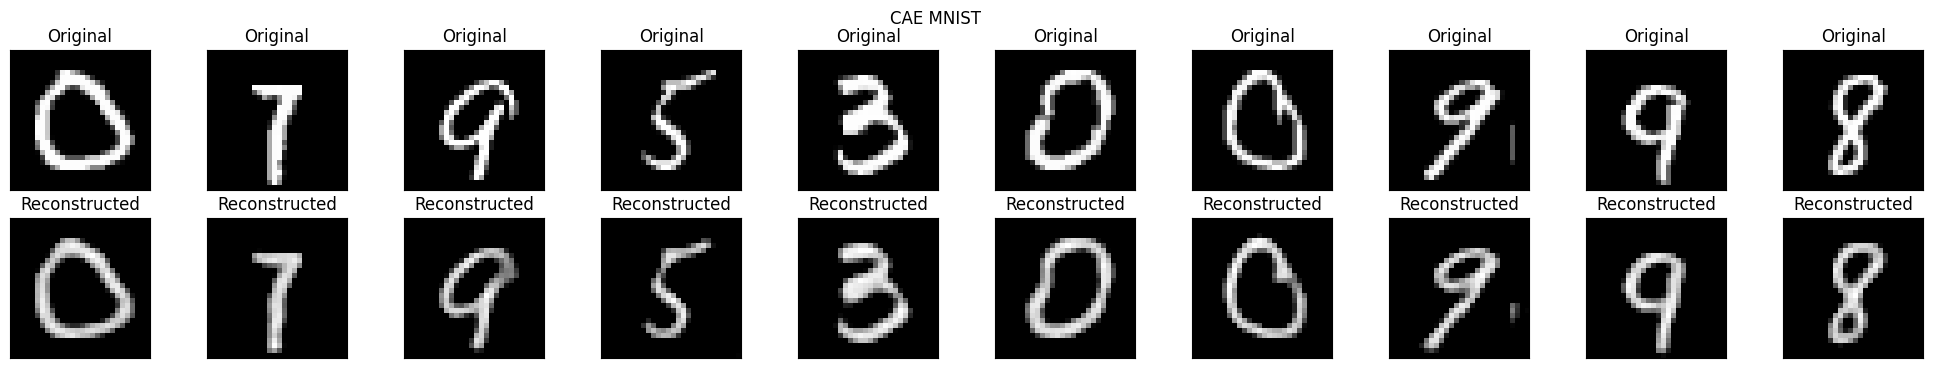

In [78]:
plotOrgRecons(model, 'CAE MNIST')

## Que 2b

In [64]:
latent_rep = []
labels_test = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model.encode(images)
        latent_rep.append(outputs.cpu().numpy())
        labels_test.append(labels.numpy())

latent_rep = np.concatenate(latent_rep, axis=0)
labels_test = np.concatenate(labels_test, axis=0)

print(latent_rep.shape, labels_test.shape)

(14000, 100) (14000,)


In [66]:
# tsne plot
tsne = TSNE(n_components=2, random_state=seed)

latent_data = np.array(latent_rep).reshape(-1, latent_rep.shape[-1])
latent_tsne = tsne.fit_transform(latent_data)


Text(0.5, 1.0, 'TSNE plot of latent representation')

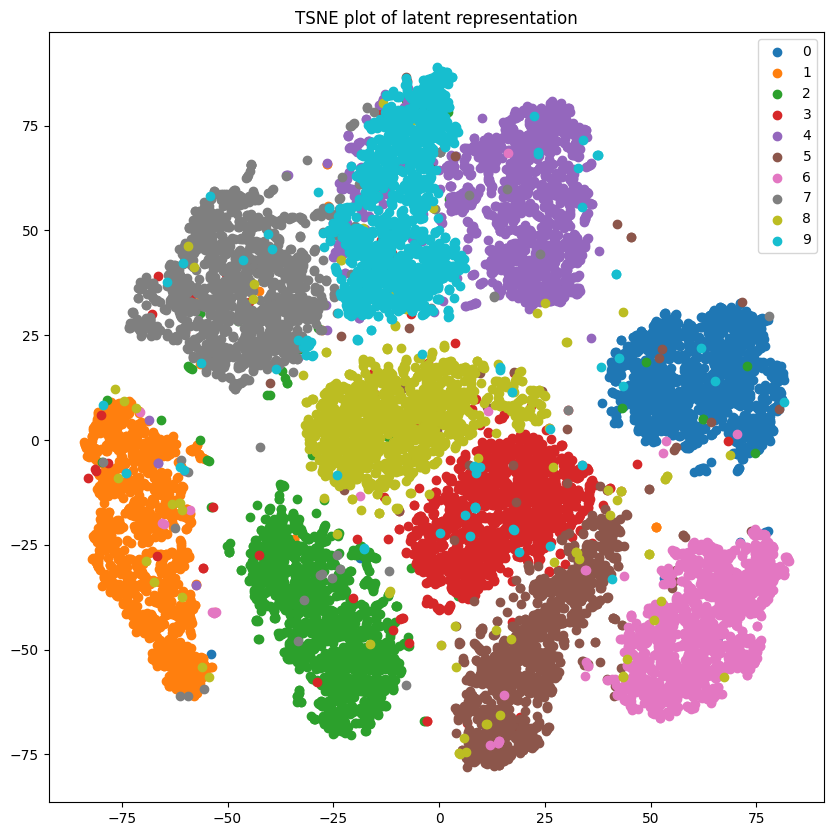

In [68]:
# plot tsne
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.scatter(latent_tsne[labels_test == i, 0], latent_tsne[labels_test == i, 1], label=str(i))
plt.legend()
plt.title('TSNE plot of latent representation')


## 2 (c)

/tmp/ipykernel_238814/3046722577.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{curr_path}/output_cae_noise_{noise}/best_model.pth")

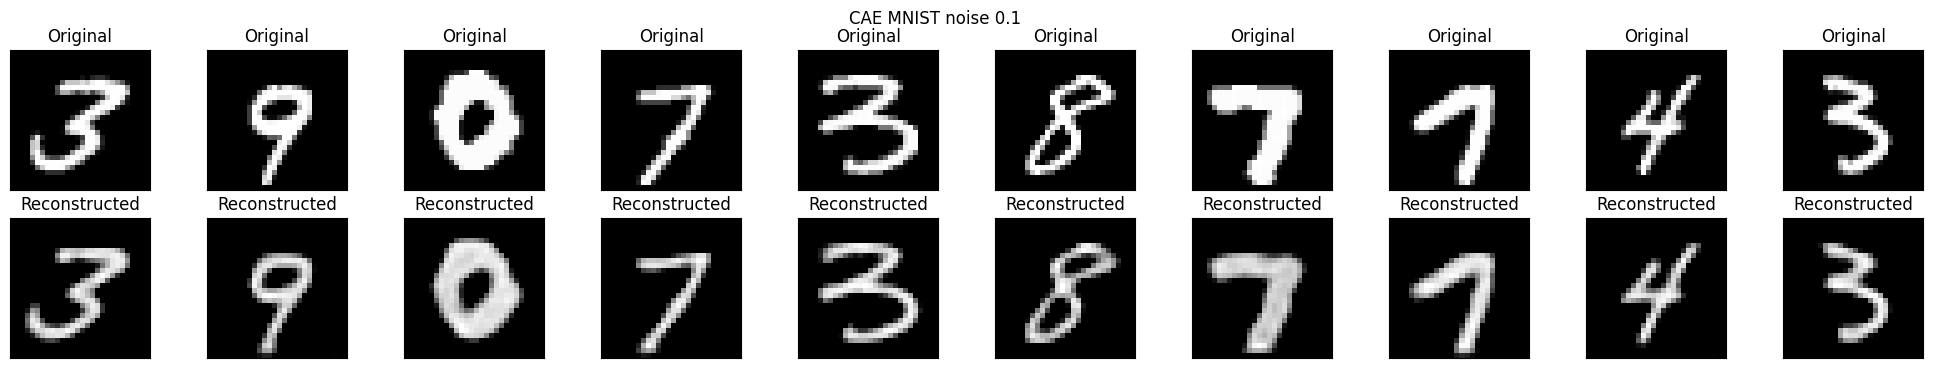

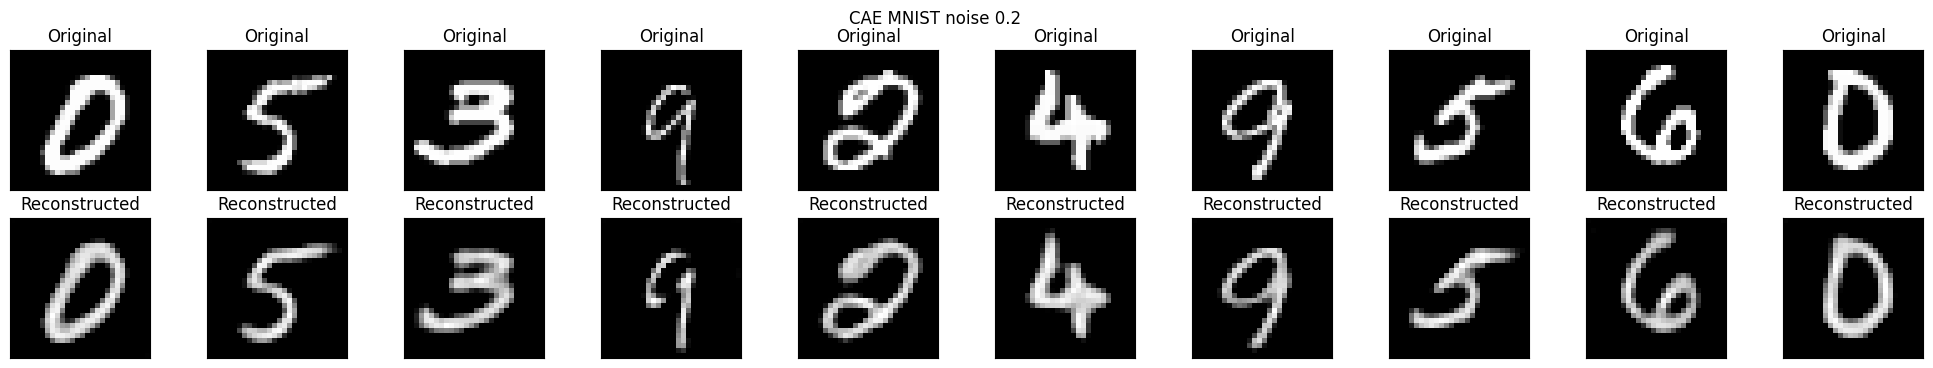

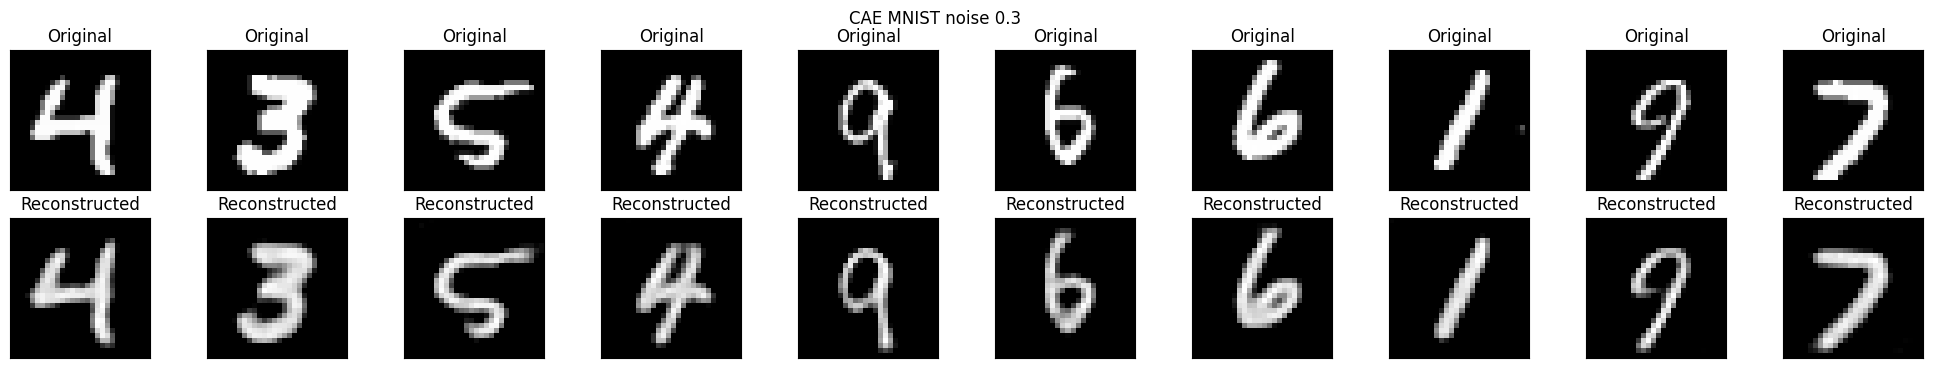

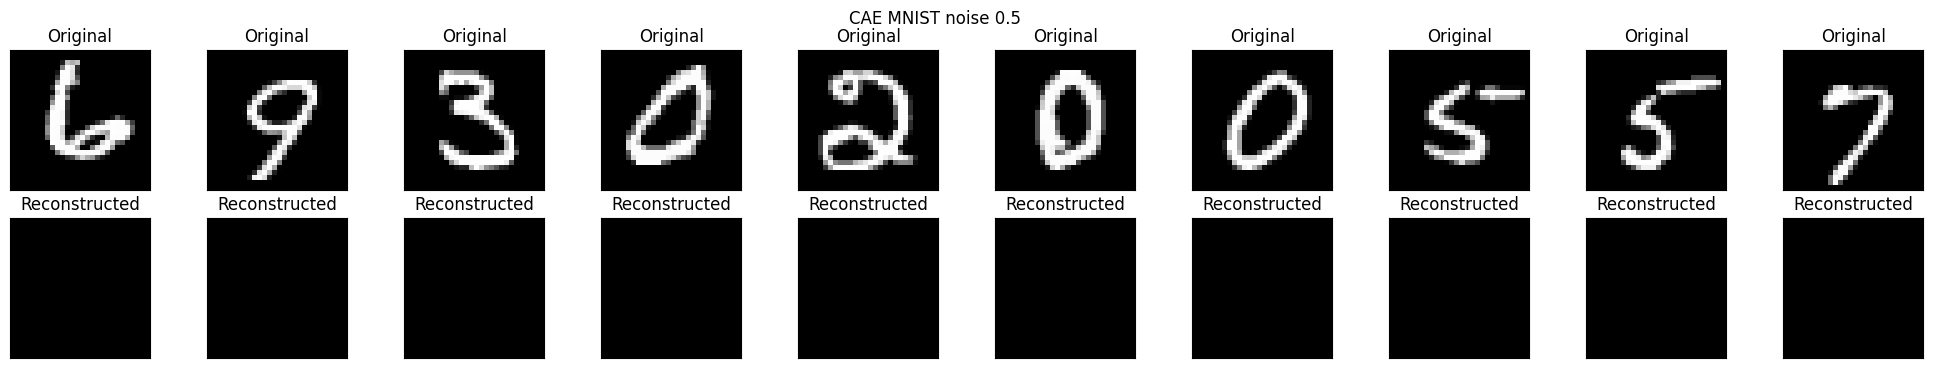

In [79]:
model = CAE(**configCAEBest).to(device)
curr_path = os.getcwd()
noise_vals = [0.1, 0.2, 0.3, 0.5]
for noise in noise_vals:
    model.load_state_dict(torch.load(f"{curr_path}/output_cae_noise_{noise}/best_model.pth"))
    plotOrgRecons(model, f'CAE MNIST noise {noise}')

In [83]:
# get PSNR for each noise level
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

model = CAE(**configCAEBest).to(device)
curr_path = os.getcwd()
noise_vals = [0.1, 0.2, 0.3, 0.5]
for noise in noise_vals:
    model.load_state_dict(torch.load(f"{curr_path}/output_cae_noise_{noise}/best_model.pth"))
    model.eval()
    psnr_global = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images
            noisy_images = add_noise(images, noise_factor=noise).to(device)
            images = images.to(device)
            outputs = model(noisy_images)
            
            psnr_val = psnr(images.cpu().numpy(), outputs.cpu().numpy())
            psnr_global += psnr_val

    print(f'PSNR for noise {noise}: {psnr_global/len(test_loader)}')


/tmp/ipykernel_238814/3096312244.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{curr_path}/output_cae_noise_{noise}/best_model.pth"

PSNR for noise 0.1: 23.142070589759868
PSNR for noise 0.2: 22.405205666103914
PSNR for noise 0.3: 21.438897404576817
PSNR for noise 0.5: 9.502680654787813


In [86]:
# ssim sklearn
from skimage.metrics import structural_similarity as ssim
model = CAE(**configCAEBest).to(device)
curr_path = os.getcwd()
noise_vals = [0.1, 0.2, 0.3, 0.5]
for noise in noise_vals:
    model.load_state_dict(torch.load(f"{curr_path}/output_cae_noise_{noise}/best_model.pth"))
    model.eval()
    ssim_global = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images
            noisy_images = add_noise(images, noise_factor=noise).to(device)
            images = images.to(device)
            outputs = model(noisy_images)
            
            for i in range(images.shape[0]):
                ssim_val = ssim(images[i][0].cpu().numpy(), outputs[i][0].cpu().numpy(), data_range=max(outputs[i][0].cpu().numpy().max(), images[i][0].cpu().numpy().max()))
                ssim_global += ssim_val

    print(f'SSIM for noise {noise}: {ssim_global/(len(test_loader)*64)}')


/tmp/ipykernel_238814/3872216764.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{curr_path}/output_cae_noise_{noise}/best_model.pth")

SSIM for noise 0.1: 0.9475038009237008
SSIM for noise 0.2: 0.9360010542848133
SSIM for noise 0.3: 0.9188558875237498
SSIM for noise 0.5: 0.24064626254246085


## 2 (d)

/tmp/ipykernel_238814/22619058.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{curr_path}/output_cae_noise_{noise}/best_model.pth"))


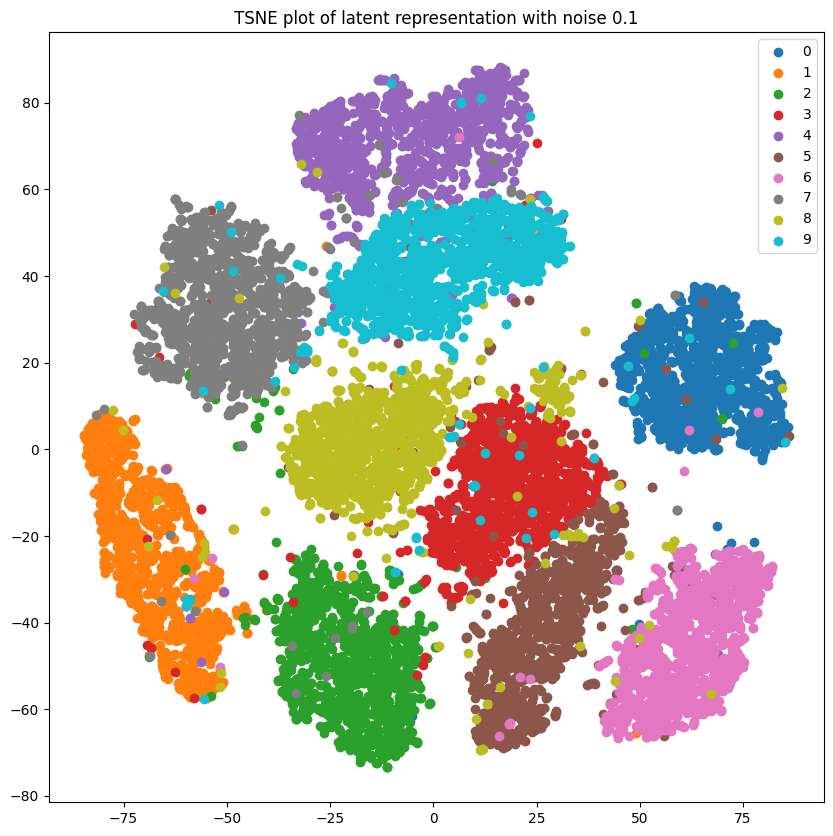

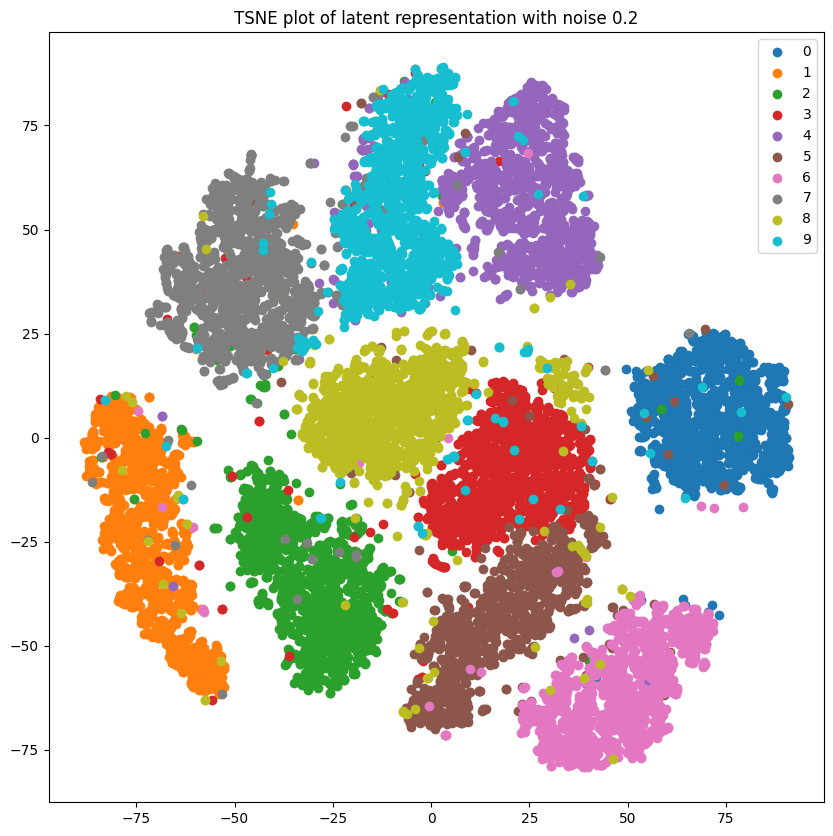

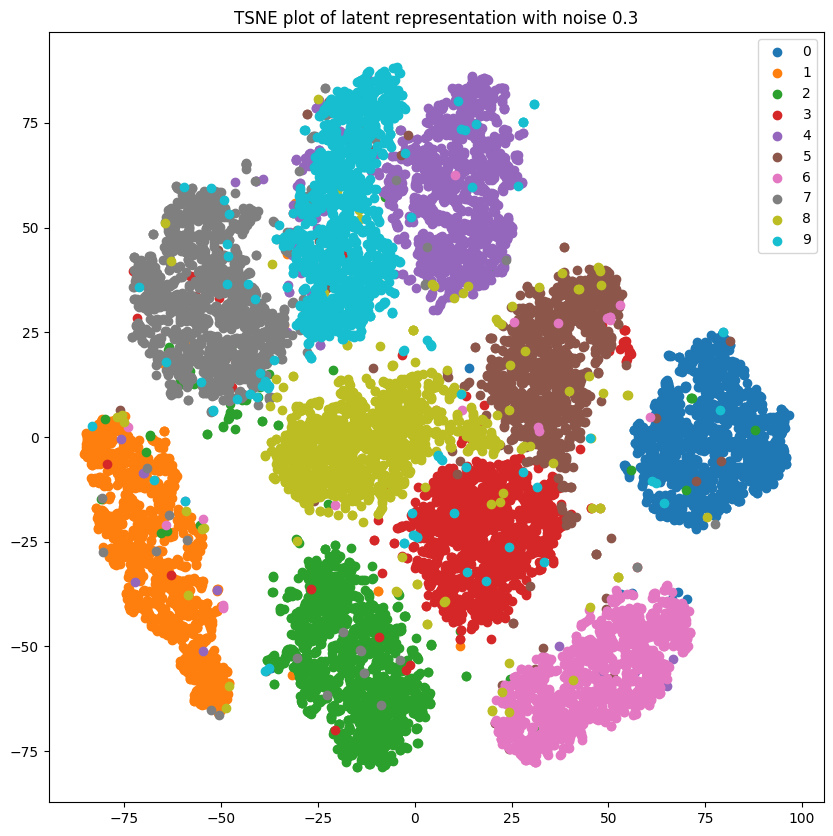

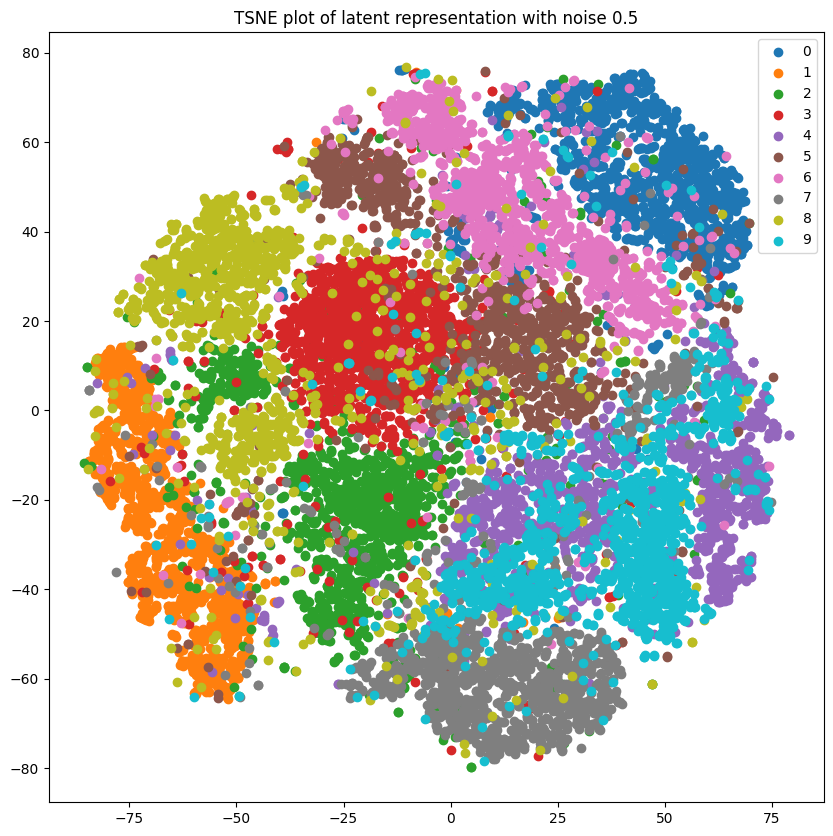

In [80]:
model = CAE(**configCAEBest).to(device)
curr_path = os.getcwd()
noise_vals = [0.1, 0.2, 0.3, 0.5]
for noise in noise_vals:
    model.load_state_dict(torch.load(f"{curr_path}/output_cae_noise_{noise}/best_model.pth"))
    latent_rep = []
    labels_test = []

    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model.encode(images)
            latent_rep.append(outputs.cpu().numpy())
            labels_test.append(labels.numpy())

    latent_rep = np.concatenate(latent_rep, axis=0)
    labels_test = np.concatenate(labels_test, axis=0)

    # print(latent_rep.shape, labels_test.shape)

    # tsne plot
    tsne = TSNE(n_components=2, random_state=seed)

    latent_data = np.array(latent_rep).reshape(-1, latent_rep.shape[-1])
    latent_tsne = tsne.fit_transform(latent_data)


    # plot tsne
    plt.figure(figsize=(10, 10))
    for i in range(10):
        plt.scatter(latent_tsne[labels_test == i, 0], latent_tsne[labels_test == i, 1], label=str(i))
    plt.legend()
    plt.title(f'TSNE plot of latent representation with noise {noise}')

- TSNE plot becomes more mixed/overlapping (in terms of color) as noise_factor increases
- As comparision to 2 (a), noise_factors [0.1, 0.2] TSNE are almost same but two clusters are formed for yellow class.